<a href="https://colab.research.google.com/github/mk-armah/BECE-Grade-Analysis/blob/master/NeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split

tf.random.set_seed(111)

In [2]:
! git clone https://github.com/mk-armah/BECE-Grade-Analysis

Cloning into 'BECE-Grade-Analysis'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 11), reused 13 (delta 3), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [3]:
os.chdir("/content/BECE-Grade-Analysis") 
os.getcwd()

'/content/BECE-Grade-Analysis'

In [4]:
df = pd.read_csv("cleaned_data.xlsx")
df.head()

,Unnamed: 0,cid,social_studies,integrated_science,i_c_t,r_m_e,fante,mathematics,english_language,b_d_t,schtype,age,gender,circuit,aggregate
0,0,302063052,1,1,1,2,2,1,2,2,PRIVATE,15.0,M,SALTPOND B,8.0
1,1,302063055,1,2,4,4,4,5,3,3,PRIVATE,15.0,F,SALTPOND B,18.0
2,2,302156005,1,3,5,2,3,4,5,5,PUBLIC,19.0,M,MANKESSIM A,18.0
3,3,302063042,1,1,2,2,2,2,1,2,PRIVATE,16.0,M,SALTPOND B,9.0
4,4,302148014,1,4,6,3,2,5,4,4,PUBLIC,17.0,M,MDOMINASE,19.0


In [5]:
df = df.drop(df.iloc[:,[0]].columns,axis = 1) #drop unnamed: 0 column

In [6]:
df.isna().sum()

cid                   0
social_studies        0
integrated_science    0
i_c_t                 0
r_m_e                 0
fante                 0
mathematics           0
english_language      0
b_d_t                 0
schtype               0
age                   0
gender                0
circuit               0
aggregate             0
dtype: int64

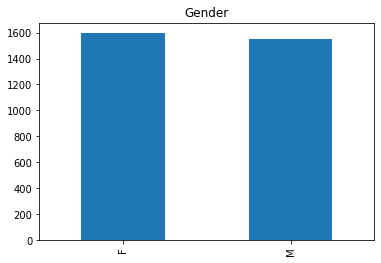

In [7]:
df.gender.value_counts().plot(kind = 'bar');
plt.title("Gender");

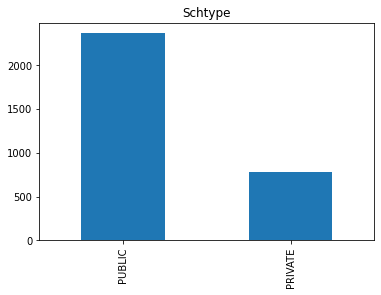

In [8]:
df.schtype.value_counts().plot(kind = 'bar');
plt.title("Schtype");

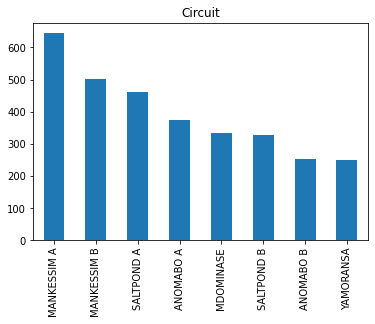

In [9]:
df.circuit.value_counts().plot(kind = 'bar');
plt.title("Circuit");

In [10]:
def encoder(column):
  """convert categories to encodings"""
  data={}
  for enum,i in enumerate(list(df[column].value_counts().index)):
    data[i] = enum
  return data

In [11]:
for i in list(df.select_dtypes("O").columns):
  df[i] = df[i].map(encoder(i))

In [12]:
df.head()

,cid,social_studies,integrated_science,i_c_t,r_m_e,fante,mathematics,english_language,b_d_t,schtype,age,gender,circuit,aggregate
0,302063052,1,1,1,2,2,1,2,2,1,15.0,1,5,8.0
1,302063055,1,2,4,4,4,5,3,3,1,15.0,0,5,18.0
2,302156005,1,3,5,2,3,4,5,5,0,19.0,1,0,18.0
3,302063042,1,1,2,2,2,2,1,2,1,16.0,1,5,9.0
4,302148014,1,4,6,3,2,5,4,4,0,17.0,1,4,19.0


In [87]:
X  = df.iloc[:,[1,5,7,8,10,11,12,13]]
y = df.iloc[:,df.columns=='i_c_t'].astype("float32")

In [89]:
y = tf.keras.utils.to_categorical(y) #convert y to one-hot-encodings

In [131]:
def data_splitter(scale = True):
  """split the data into training and validation split
  scale: if True the training and testing data will be scaled using x' = (x - μ) / σ
  where x is a datapoint of the column to be scaled, μ is the mean and σ is the standard deviation"""
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 111,stratify = y)

  if scale:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

  return X_train, X_test, y_train, y_test

In [132]:
X_train, X_test, y_train, y_test = data_splitter(scale = True)

In [133]:
print("shape of X",((X_train.size/X.size)*100),"%")
print("shape of X",((X_test.size/X.size)*100),"%")

shape of X 79.98727330575883 %
shape of X 20.01272669424117 %


In [115]:
class NeuralNet(tf.keras.Model):
  def __init__(self,out_layer,in_layers = [32,64,128]):
    super(NeuralNet,self).__init__()
    self.in_layers = in_layers
    self.out_layer = out_layer
    
    self.first_layer = tf.keras.layers.Dense(self.in_layers[0],name = "first_layer",activation = 'relu',input_shape = (8,))
   # self.dropout = tf.keras.layers.Dropout(0.2,name = 'dropout')
    self.second_layer  = tf.keras.layers.Dense(self.in_layers[1],name = "second_layer",activation = 'relu')
    self.third_layer = tf.keras.layers.Dense(self.in_layers[2],name = "third_layer",activation = 'relu')
    self.last_layer = tf.keras.layers.Dense(self.out_layer,name = "last_layer",activation="softmax")

  def call(self,x):
    x = self.first_layer(x)
    x = self.second_layer(x)
    #x = self.dropout = self.dropout(x)
    x = self.third_layer(x)
    output = self.last_layer(x)
    return output

In [116]:
model = NeuralNet(out_layer = 10)

In [117]:
model.compile(optimizer='adam', # use adaptive momentum
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
# Train the Model
history = model.fit(X, y, validation_data=(X_test, y_test),epochs= 500) #training for 500 epochs

Epoch 1/500
99/99 [==============================] - 2s 9ms/step - loss: 1.7055 - accuracy: 0.3073 - val_loss: 1.4500 - val_accuracy: 0.3704
Epoch 2/500
99/99 [==============================] - 0s 5ms/step - loss: 1.4839 - accuracy: 0.3293 - val_loss: 1.4601 - val_accuracy: 0.3418
Epoch 3/500
99/99 [==============================] - 0s 4ms/step - loss: 1.4675 - accuracy: 0.3299 - val_loss: 1.4248 - val_accuracy: 0.3943
Epoch 4/500
99/99 [==============================] - 1s 6ms/step - loss: 1.4571 - accuracy: 0.3436 - val_loss: 1.3917 - val_accuracy: 0.3816
Epoch 5/500
99/99 [==============================] - 1s 6ms/step - loss: 1.4323 - accuracy: 0.3404 - val_loss: 1.4331 - val_accuracy: 0.3672
Epoch 6/500
99/99 [==============================] - 1s 5ms/step - loss: 1.4211 - accuracy: 0.3618 - val_loss: 1.3758 - val_accuracy: 0.3943
Epoch 7/500
99/99 [==============================] - 0s 5ms/step - loss: 1.4167 - accuracy: 0.3567 - val_loss: 1.3889 - val_accuracy: 0.3990
Epoch 8/500
9

In [123]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


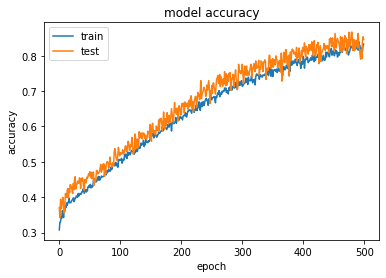

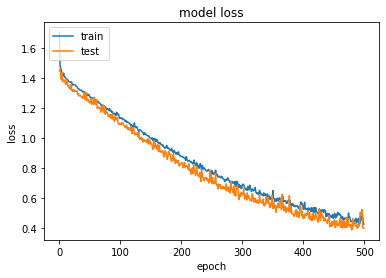

In [125]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()